In [1]:
!nvidia-smi

Sat Nov  9 12:49:31 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.183      Driver Version: 384.183      CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000C93:00:00.0 Off |                    0 |
| N/A   46C    P0    72W / 149W |   2486MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           Off  | 00002BD8:00:00.0 Off |                    0 |
| N/A   61C    P0    61W / 149W |   2226MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [90]:
from tqdm import tqdm_notebook as tqdm

In [7]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3" # set gpu number to use

from comet_ml import Experiment

import torch
import torch.nn as nn
import torch.utils as utils
import torch.nn.init as init
from torch.autograd import Variable
import torchvision.utils as v_utils
import torchvision.datasets as dset
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

%matplotlib inline

In [8]:
anomaly_digit = 0
batch_size = 256

In [9]:
not_ano_dataset = dset.MNIST("../../../data/", train=True, 
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize([0.5], [0.5]),
                        ]),
                        target_transform=None,
                        download=True)

condition = not_ano_dataset.targets != anomaly_digit
not_ano_dataset.data = not_ano_dataset.data[condition]
not_ano_dataset.targets = not_ano_dataset.targets[condition]

not_ano_loader = torch.utils.data.DataLoader(dataset=not_ano_dataset,batch_size=batch_size,shuffle=True,drop_last=True)

In [37]:
# Generator receives random noise z and create 1x28x28 image
# we can name each layer using OrderedDict

class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.layer1 = nn.Sequential(
             nn.Linear(100,392),
             nn.BatchNorm1d(392),
             nn.ReLU(),
        )
        self.layer2 = nn.Sequential(
                        nn.ConvTranspose2d(4,16,3,2,1,1),
                        nn.LeakyReLU(),
            
                        nn.ConvTranspose2d(16,32,3,1,1),
                        nn.LeakyReLU(),
            )
        self.layer3 = nn.Sequential(
                        nn.ConvTranspose2d(32,16,3,1,1),
                        nn.BatchNorm2d(16),    
                        nn.LeakyReLU(),
                        nn.ConvTranspose2d(16, 1,3,2,1,1),
                        nn.Tanh()
            )

    def forward(self,z):
        out = self.layer1(z)
        out = out.view(out.size()[0],4,16,16)
        out = self.layer2(out)
        out = self.layer3(out)
        return out

In [38]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(1,8,3,padding=1),   # batch x 16 x 28 x 28
                        nn.BatchNorm2d(8),    
                        nn.LeakyReLU(),
                        nn.Conv2d(8,16,3, padding=1),  # batch x 32 x 28 x 28
                        nn.BatchNorm2d(16),    
                        nn.LeakyReLU(),
                        nn.MaxPool2d(2,2)   # batch x 32 x 14 x 14
        )
        self.layer2 = nn.Sequential(
                        nn.Conv2d(16,32,3,padding=1),  # batch x 64 x 14 x 14
                        nn.BatchNorm2d(32),
                        nn.LeakyReLU(),
                        nn.MaxPool2d(2,2),
                        nn.Conv2d(32,64,3,padding=1),  # batch x 128 x 7 x 7
                        nn.BatchNorm2d(64),
                        nn.LeakyReLU()
        )
        self.fc = nn.Sequential(
                        nn.Linear(64*7*7,1),
                        nn.Sigmoid()
        )

    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size()[0], -1)
        feature = out
        out = self.fc(out)
        return out,feature

In [39]:
import torch
from torchvision.utils import make_grid
from torchsummary import summary

def run_an_experiment(lr, n_epochs = 20, sample_interval = 100):
    experiment = Experiment(api_key = 'fcQ6lceLdmViH5KysjfD4mkz7', project_name='AnoGAN—MNIST', workspace='Sirius-yandex-2019')
    
    experiment.log_parameter('n_epochs', n_epochs)
    experiment.log_parameter('lr', lr)

    generator = Generator().to('cuda')
    print(summary(generator, (100, )))
    
    discriminator = Discriminator().to('cuda')
    print(summary(discriminator, (1, 28, 28)))

    optimizer_G = torch.optim.Adam(generator.parameters(), lr=10*lr)
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr)

    Tensor = torch.cuda.FloatTensor

    adversarial_loss = torch.nn.BCELoss()

    batches_done = 0
    
    generator.train()
    discriminator.train()

    for epoch in range(n_epochs):

        for i, (imgs, _) in enumerate(not_ano_loader):
            
            valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False).to('cuda')
            fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False).to('cuda')


            real_imgs = Variable(imgs.type(Tensor).cuda())

            optimizer_G.zero_grad()

            z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], 100)))).to('cuda')
            fake_imgs = generator(z)
            
            loss_G = adversarial_loss(discriminator(fake_imgs)[0], valid)
            loss_G.backward()
            optimizer_G.step()
            
            
            optimizer_D.zero_grad()
            
            err_r = adversarial_loss(discriminator(real_imgs)[0], valid)
            err_z = adversarial_loss(discriminator(fake_imgs.detach())[0], fake)
            loss_D = (err_r + err_z) / 2

            loss_D.backward()
            optimizer_D.step()

            experiment.log_metrics({'G': loss_G.item(), 'D': loss_D.item()}, epoch = epoch, step = batches_done)

            if batches_done % sample_interval == 0:
                plt.figure(figsize = (10,10))

                plt.title(
                    "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                    % (epoch, n_epochs, batches_done % len(not_ano_loader), len(not_ano_loader), loss_D.item(), loss_G.item())
                )

                plt.imshow(make_grid(fake_imgs.data[:25]).cpu().detach().numpy()[0, :, :])
                experiment.log_figure()
                plt.show()
            batches_done += 1

    experiment.end()
    return generator, discriminator

COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/sirius-yandex-2019/anogan-mnist/e02c6cdafc1f49708a1ea243c9044fda
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     D [17]                   : (0.25616365671157837, 0.7309645414352417)
COMET INFO:     G [17]                   : (0.7040396928787231, 1.5060402154922485)
COMET INFO:     loss [3]                 : (0.3761596083641052, 1.2215454578399658)
COMET INFO:     sys.gpu.0.free_memory    : (9388556288.0, 9388556288.0)
COMET INFO:     sys.gpu.0.gpu_utilization: (0.0, 0.0)
COMET INFO:     sys.gpu.0.total_memory   : (11995578368.0, 11995578368.0)
COMET INFO:     sys.gpu.0.used_memory    : (2607022080.0, 2607022080.0)
COMET INFO:     sys.gpu.1.free_memory    : (9658826752.0, 9658826752.0)
COMET INFO:     sys.gpu.1.gpu_utilization: (75.0, 75.0)
COMET INFO:     sys.gpu.1.total_memory   : (11995578368.0, 11995578368.0)
COMET INFO:     sys.gp

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 392]          39,592
       BatchNorm1d-2                  [-1, 392]             784
              ReLU-3                  [-1, 392]               0
   ConvTranspose2d-4           [-1, 16, 14, 14]           1,168
       BatchNorm2d-5           [-1, 16, 14, 14]              32
         LeakyReLU-6           [-1, 16, 14, 14]               0
   ConvTranspose2d-7           [-1, 32, 14, 14]           4,640
       BatchNorm2d-8           [-1, 32, 14, 14]              64
         LeakyReLU-9           [-1, 32, 14, 14]               0
  ConvTranspose2d-10           [-1, 16, 14, 14]           4,624
      BatchNorm2d-11           [-1, 16, 14, 14]              32
        LeakyReLU-12           [-1, 16, 14, 14]               0
  ConvTranspose2d-13            [-1, 1, 28, 28]             145
             Tanh-14            [-1, 1,

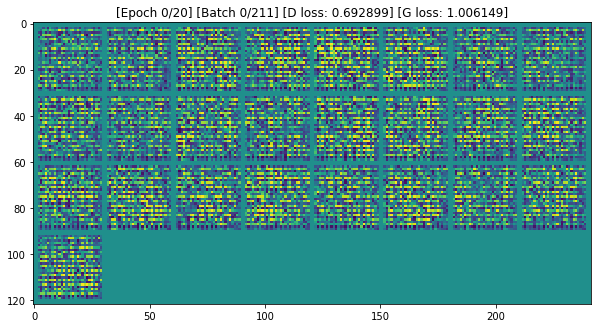

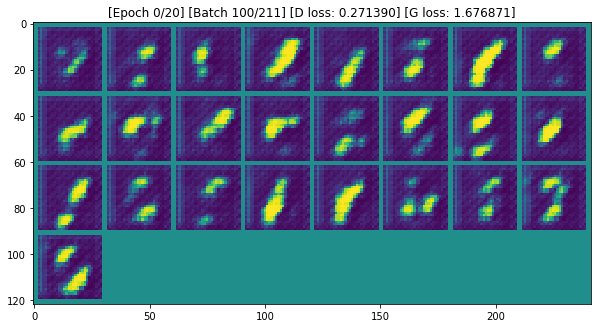

COMET ERROR: File could not be uploaded


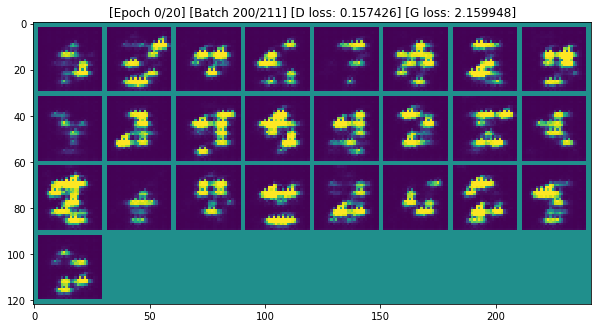

COMET ERROR: File could not be uploaded


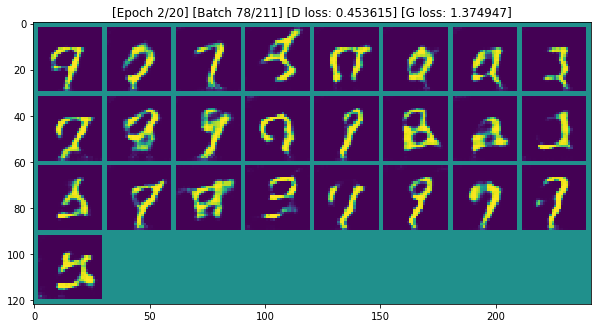

COMET ERROR: File could not be uploaded


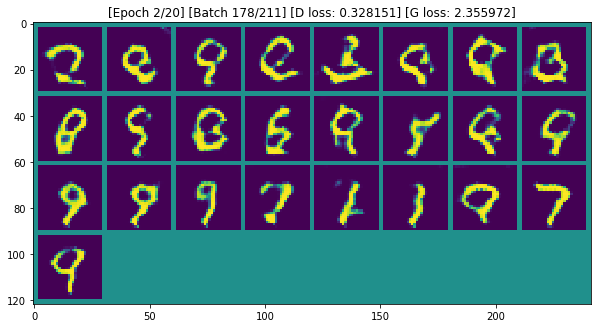

COMET ERROR: File could not be uploaded


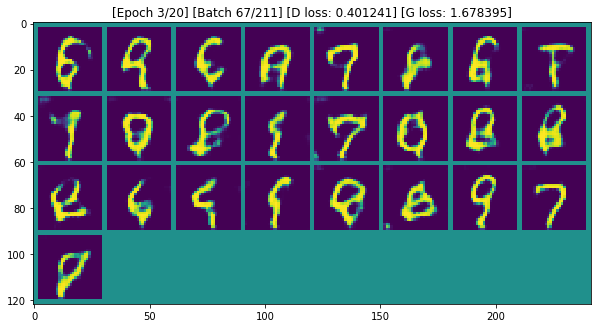

COMET ERROR: File could not be uploaded


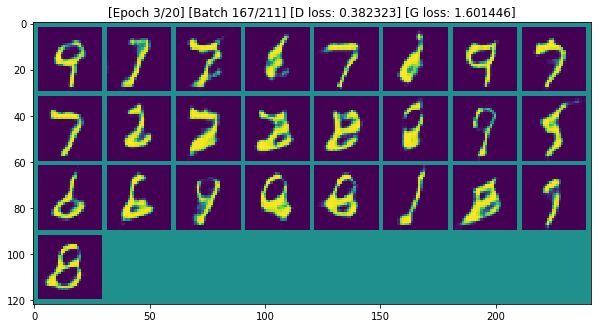

COMET ERROR: File could not be uploaded


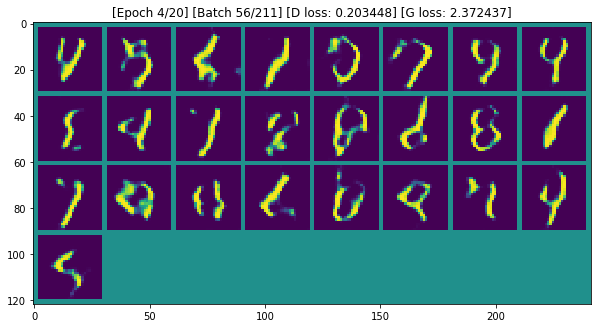

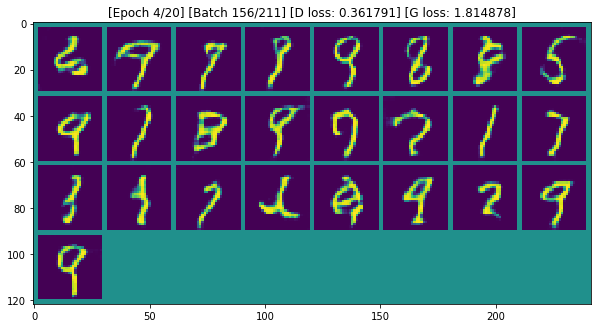

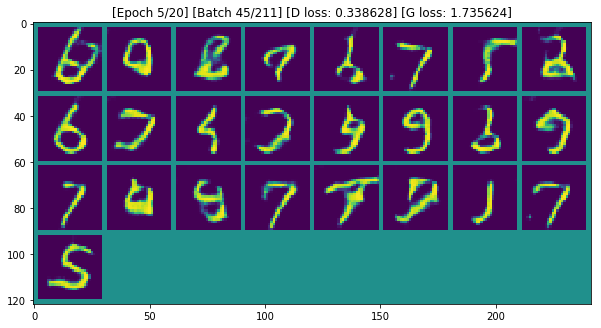

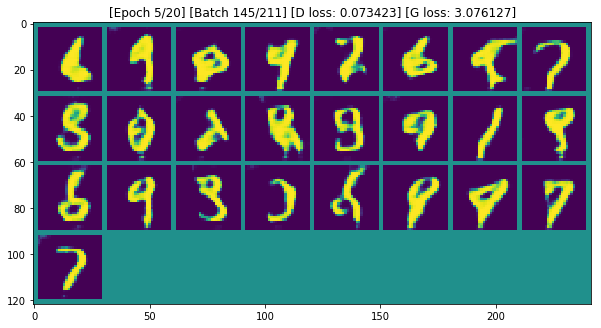

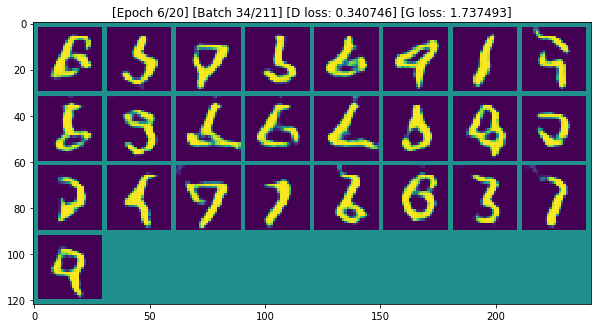

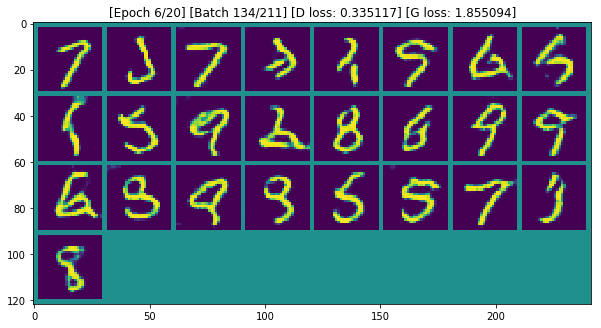

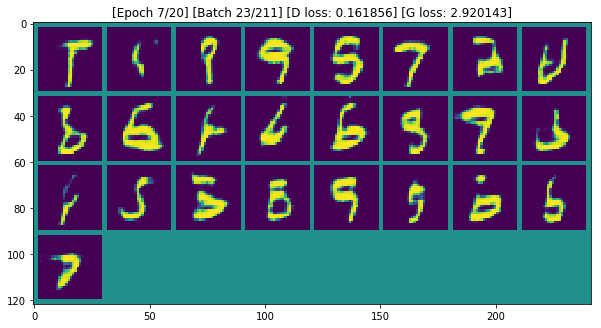

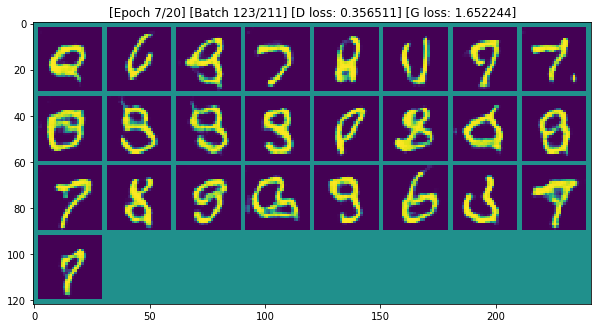

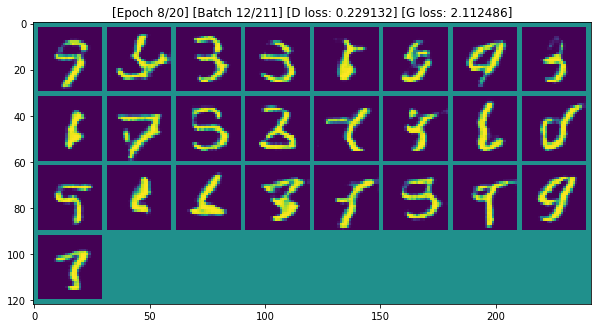

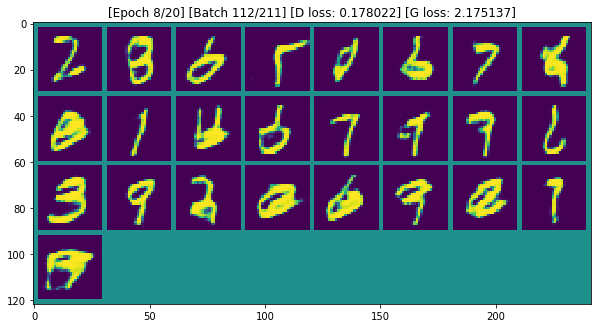

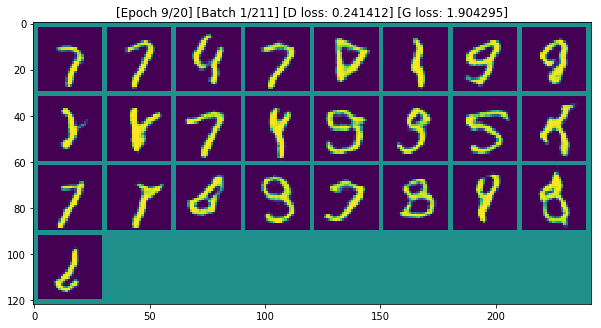

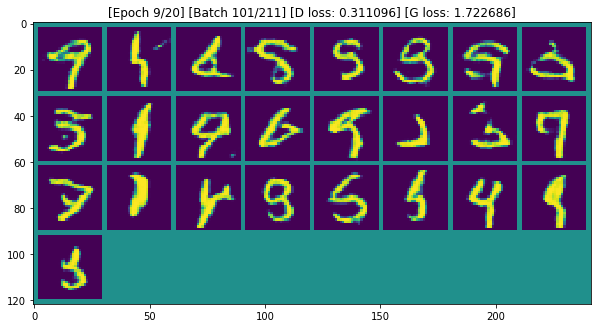

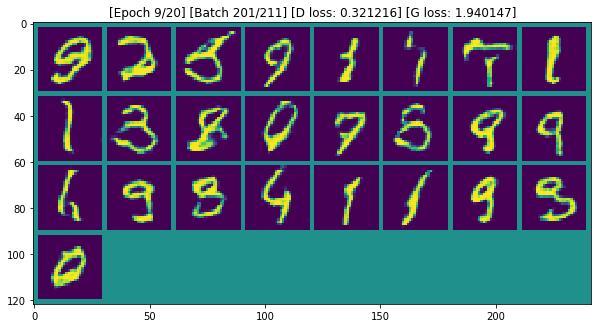

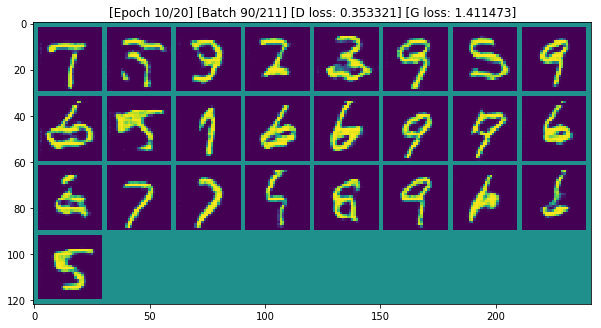

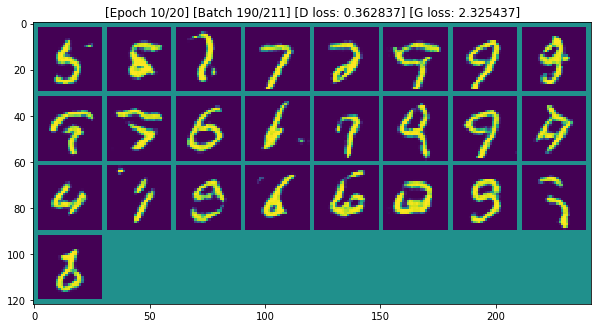

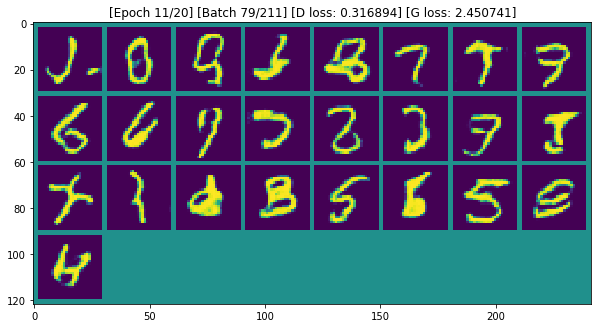

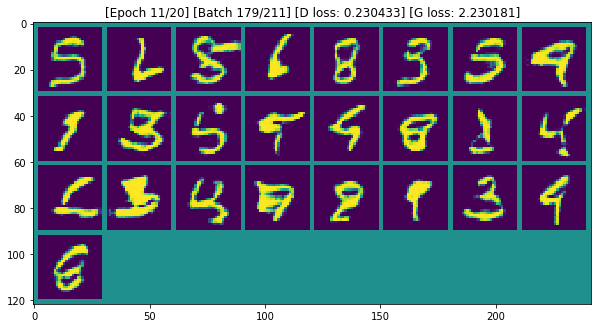

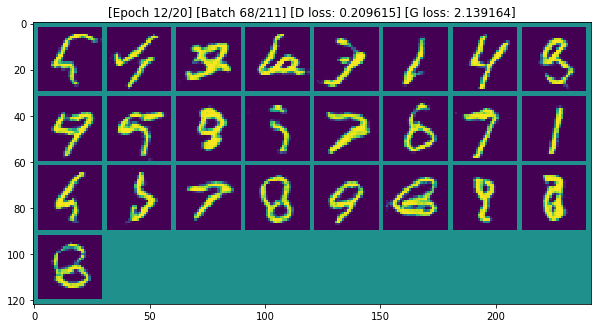

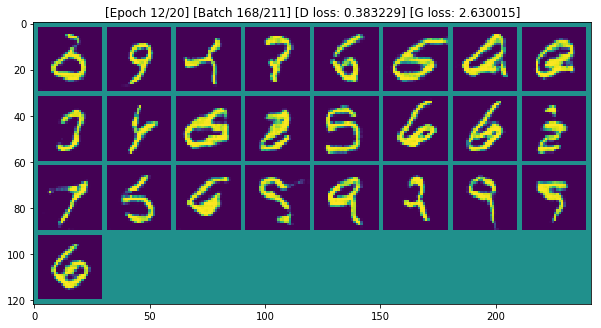

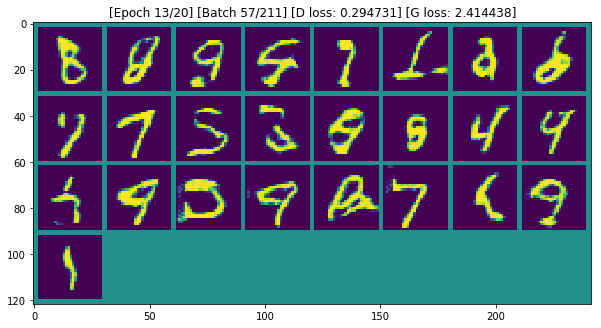

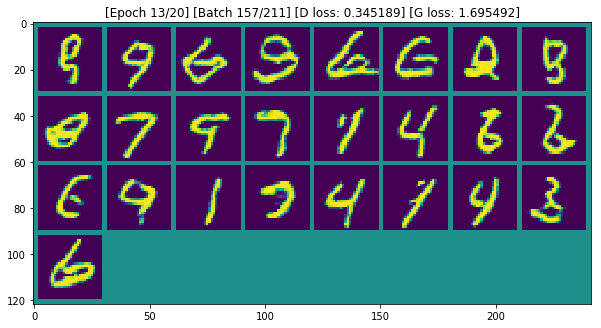

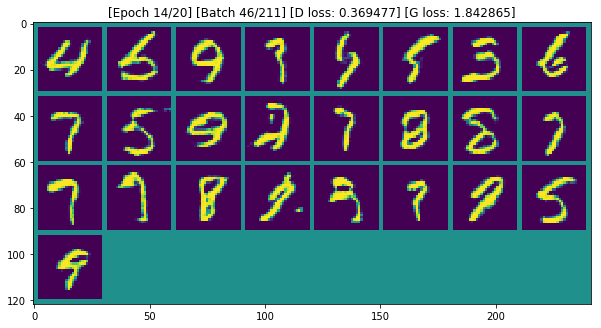

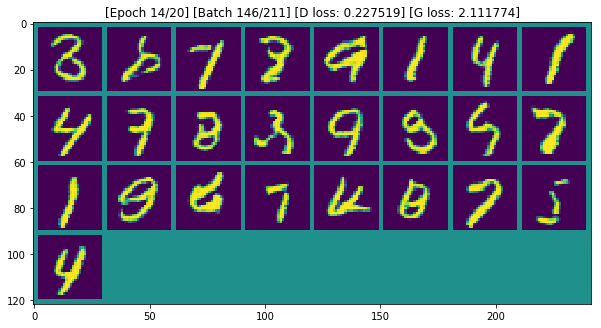

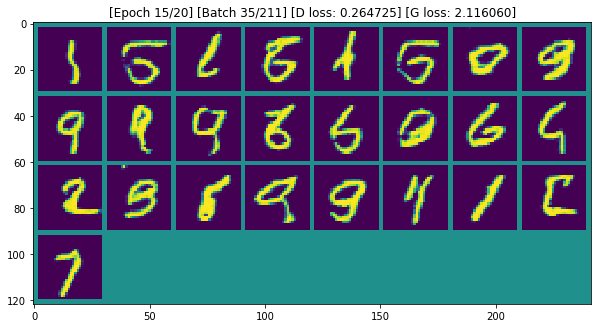

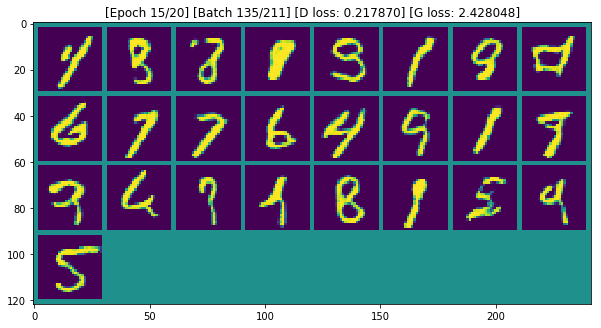

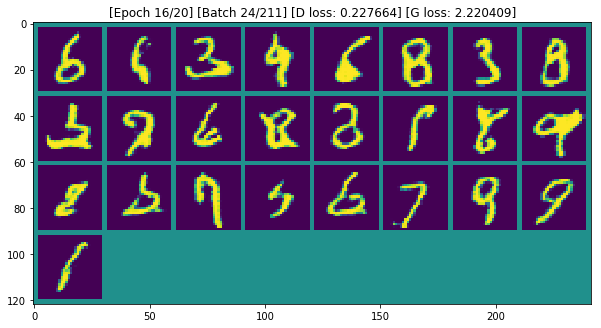

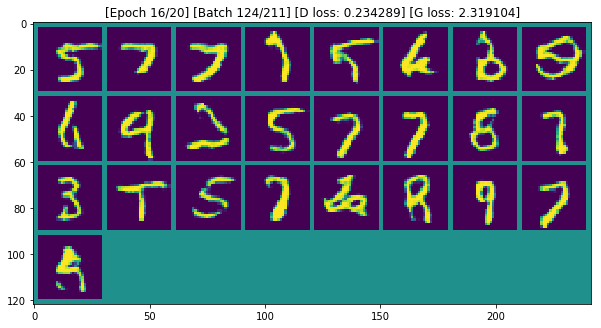

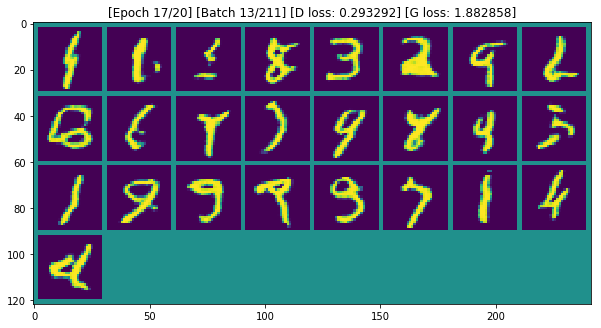

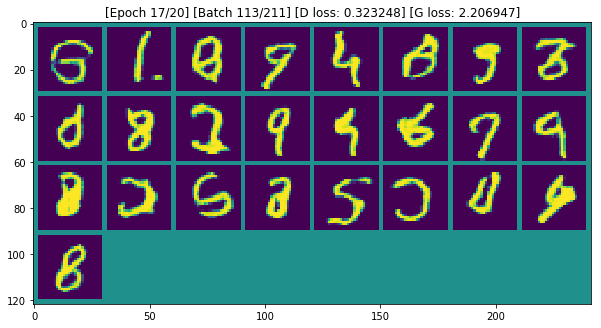

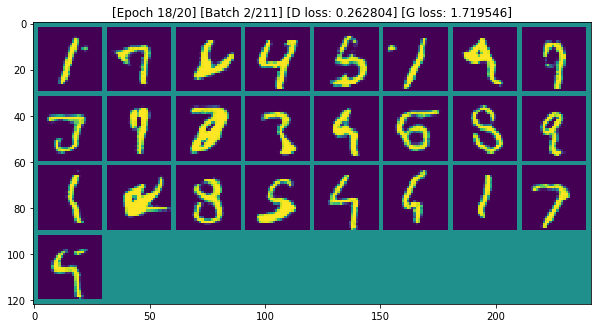

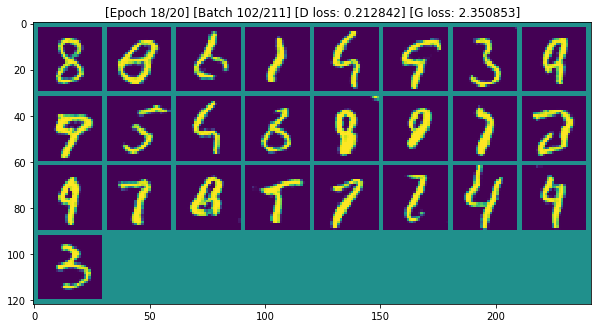

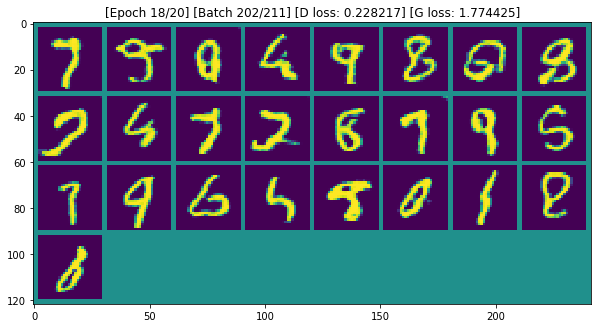

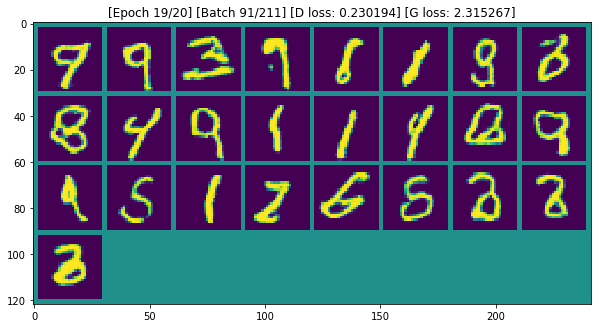

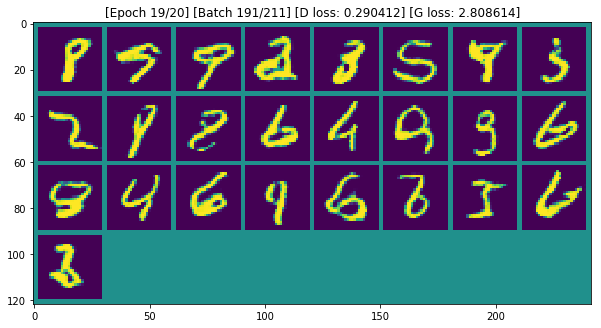

COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/sirius-yandex-2019/anogan-mnist/2f0bc0778ba945c7abbc4a845cc79c4b
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     D [4220]                      : (0.05758000910282135, 0.6928989887237549)
COMET INFO:     G [4220]                      : (0.8036156296730042, 4.222136497497559)
COMET INFO:     loss [844]                    : (0.06578157842159271, 3.6051230430603027)
COMET INFO:     sys.gpu.0.free_memory [27]    : (9388556288.0, 9388556288.0)
COMET INFO:     sys.gpu.0.gpu_utilization [27]: (0.0, 0.0)
COMET INFO:     sys.gpu.0.total_memory        : (11995578368.0, 11995578368.0)
COMET INFO:     sys.gpu.0.used_memory [27]    : (2607022080.0, 2607022080.0)
COMET INFO:     sys.gpu.1.free_memory [27]    : (9658826752.0, 9658826752.0)
COMET INFO:     sys.gpu.1.gpu_utilization [27]: (29.0, 94.0)
COMET INFO:     sys.gpu.1.total_memory        : (11

In [40]:
generator, discriminator  = run_an_experiment(0.0002)

In [41]:
import time;
ts = time.time()

for i, model in enumerate([generator, discriminator]):
    torch.save(model.state_dict(), "./models/"+str(ts)+"__"+str(i)+".pt")

# Поиск ближайших соседей
## Данные

In [43]:
mnist_train = dset.MNIST("../../../data/", train=True, 
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize([0.5], [0.5]),
                        ]),
                        target_transform=None,
                        download=True)

mnist_test = dset.MNIST("../../../data/", train=False, 
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize([0.5], [0.5]),
                        ]),
                        target_transform=None,
                        download=True)


train_loader = torch.utils.data.DataLoader(dataset=mnist_train,batch_size=batch_size,shuffle=True,drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset=mnist_test,batch_size=batch_size,shuffle=True,drop_last=True)

In [89]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

start_idx = 64
train_size = 500


train_data_mnist = mnist_train.__dict__['data'][start_idx:start_idx+train_size]
train_label_mnist = mnist_train.__dict__['targets'][start_idx:start_idx+train_size] == anomaly_digit # 0 - нормальный объект, 1 - аномалия
train_data_mnist = train_data_mnist.view(train_size,1,28,28).type_as(torch.FloatTensor())
train_data_mnist.size()

torch.Size([500, 1, 28, 28])

## Аномалии без фичер мапов

In [88]:
def Anomaly_score(x,G_z, D, Lambda=0.1): # расстояние до аномалии x до G_z. На выходе должен возвращаться тензор (batch_size,)
    return (1-Lambda) * torch.sum(torch.abs(x-G_z), 
                                  dim = [2,3])+ Lambda*torch.abs(D(x)[0] - D(G_z)[0])

In [107]:
z = Variable(init.normal(torch.zeros(train_size,100),mean=0,std=0.1),requires_grad=True) # для каждого объекта берём случайный нормальный объект в латентном пространстве в качестве начального соседа
z_optimizer = torch.optim.Adam([z],lr=10) # задаём оптимизатор для поиска ближайшего z к нашим аномалиям

losses_z = []

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  """Entry point for launching an IPython kernel.


In [ ]:
from IPython import display

for i in range(10000):
    z_optimizer.zero_grad()
    gen_fake = generator(z.cuda())
    loss = Anomaly_score(Variable(train_data_mnist).cuda(), 
                         gen_fake, discriminator, 0.1).mean() # расстояние до нормального соседа. Путём минимизации этого расстояния будем находить расстояние до ближайшего соседа
    loss.backward()
    z_optimizer.step()
    losses_z.append(loss.item())
    plt.plot(losses_z)
    plt.show()
    display.clear_output(wait=True)

False


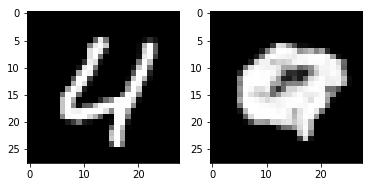




False


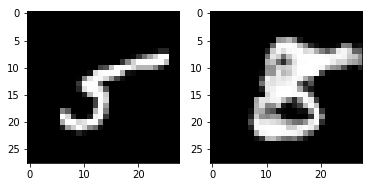




False


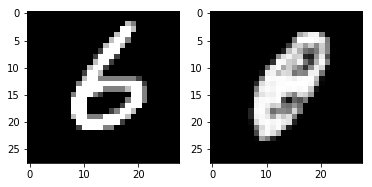




False


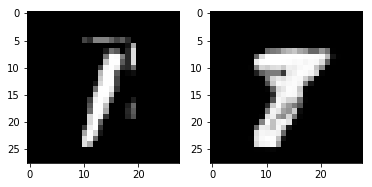




True


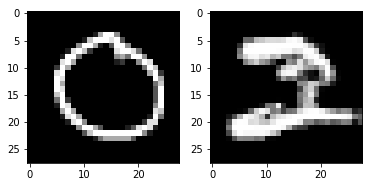




True


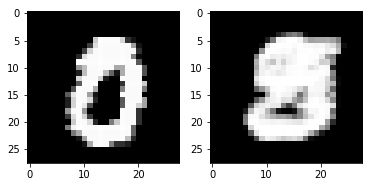




False


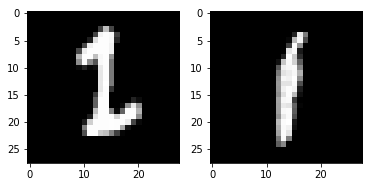




False


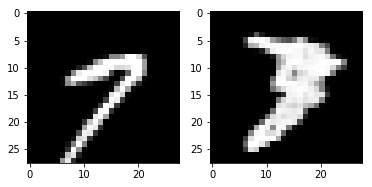




False


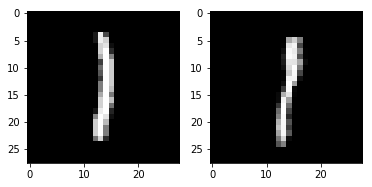




False


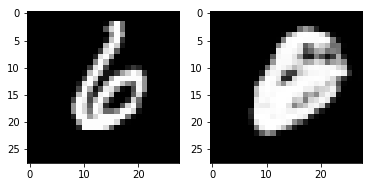

In [116]:
fake_imgs = generator(z.cuda())
for i in range(10):
    print(train_label_mnist[i].item())

    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(train_data_mnist.cpu().detach().numpy()[i][0], cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(fake_imgs.cpu().detach().numpy()[i][0], cmap='gray')
    plt.show()

    print('\n\n')

## Аномалии с фичер мапами

In [117]:
def Anomaly_score(x,G_z,Lambda=0.1): # расстояние до аномалии x до ближайшего соседа G_z
    _, x_feature = discriminator(x)
    _, G_z_feature = discriminator(G_z)
    
    residual_loss = torch.sum(torch.abs(x-G_z), dim=[1,2,3])
    discrimination_loss = torch.sum(torch.abs(x_feature-G_z_feature), 1)
    
    total_loss = (1-Lambda)*residual_loss + Lambda*discrimination_loss
    return total_loss

In [ ]:
z = Variable(init.normal(torch.zeros(train_size,100), 
                         mean=0,std=0.1),requires_grad=True) # для каждого объекта берём случайный нормальный объект в латентном пространстве в качестве начального соседа
z_optimizer = torch.optim.Adam([z],lr=10) # задаём оптимизатор для поиска ближайшего z к нашим аномалиям

losses_z = []

In [ ]:
for i in range(10000):
    z_optimizer.zero_grad()
    gen_fake = generator(z.cuda())
    loss = Anomaly_score(Variable(train_data_mnist).cuda(),
                         gen_fake, 0.1).mean() # расстояние до нормального соседа. Путём минимизации этого расстояния будем находить расстояние до ближайшего соседа
    loss.backward()
    z_optimizer.step()
    losses_z.append(loss.item())
    plt.plot(losses_z)
    plt.show()
    display.clear_output(wait=True)

False


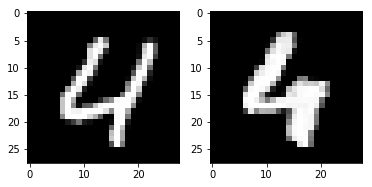




False


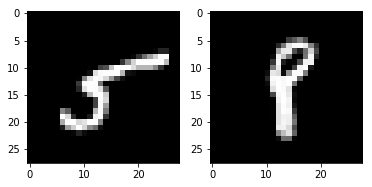




False


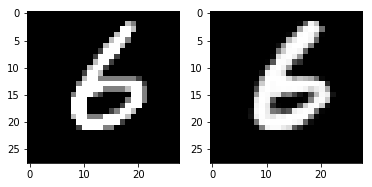




False


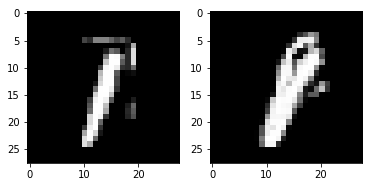




True


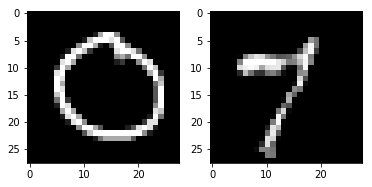




True


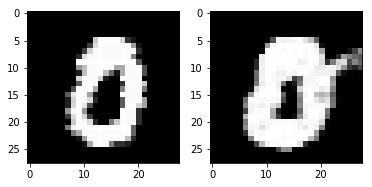




False


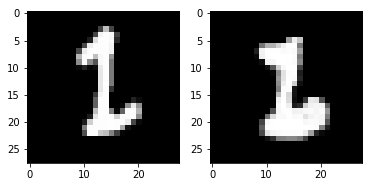




False


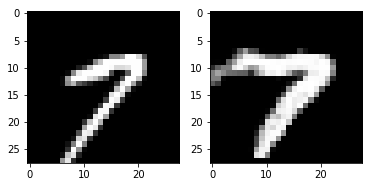




False


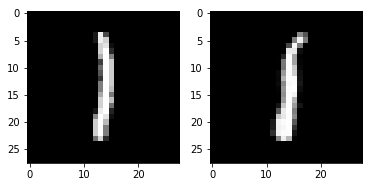




False


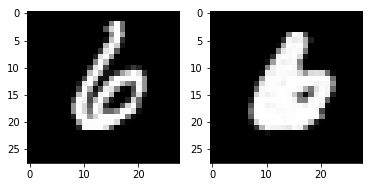

In [134]:
fake_imgs = generator(z.cuda())
for i in range(10):
    print(train_label_mnist[i].item())

    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(train_data_mnist.cpu().detach().numpy()[i][0], cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(fake_imgs.cpu().detach().numpy()[i][0], cmap='gray')
    plt.show()

    print('\n\n')

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


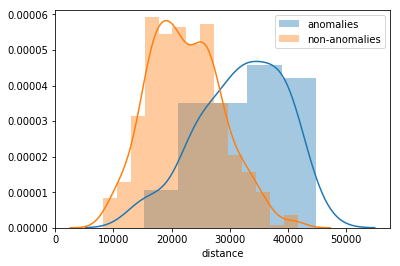

In [126]:
import seaborn as sns
loss = Anomaly_score(Variable(train_data_mnist).cuda(),fake_imgs)

sns.distplot(loss[train_label_mnist].detach().cpu().numpy(), label='anomalies')
sns.distplot(loss[~train_label_mnist].detach().cpu().numpy(), label='non-anomalies')
plt.xlabel('distance')
plt.legend()

In [140]:
from sklearn.metrics import roc_auc_score
loss = Anomaly_score(Variable(train_data_mnist).cuda(),fake_imgs)


roc_auc_score(train_label_mnist.numpy(), loss.detach().cpu().numpy())

0.832734144542773

## izi architecture

In [158]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(1,8,3,padding=1),   # batch x 16 x 28 x 28
                        nn.LeakyReLU(),
                        nn.Conv2d(8,16,3, padding=1),  # batch x 32 x 28 x 28
                        nn.LeakyReLU(),
                        nn.MaxPool2d(2,2)   # batch x 32 x 14 x 14
        )
        self.layer2 = nn.Sequential(
                        nn.Conv2d(16,32,3,padding=1),  # batch x 64 x 14 x 14
                        nn.LeakyReLU(),
                        nn.MaxPool2d(2,2),
                        nn.Conv2d(32,64,3,padding=1),  # batch x 128 x 7 x 7
                        nn.LeakyReLU()
        )
        self.fc = nn.Sequential(
                        nn.Linear(64*7*7,100),
        )

    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size()[0], -1)
        feature = out
        out = self.fc(out)
        return out,feature

In [159]:
encoder = Encoder().cuda()
opt_E = torch.optim.Adam(encoder.parameters(),lr=1e-4) # задаём оптимизатор для поиска ближайшего z к нашим аномалиям

MSE_AE = nn.MSELoss()

In [160]:
not_ano_dataset_test = dset.MNIST("../../../data/", train=False, 
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize([0.5], [0.5]),
                        ]),
                        target_transform=None,
                        download=True)

condition = not_ano_dataset_test.targets != anomaly_digit
not_ano_dataset_test.data = not_ano_dataset_test.data[condition]
not_ano_dataset_test.targets = not_ano_dataset_test.targets[condition]

not_ano_loader_test = torch.utils.data.DataLoader(dataset=not_ano_dataset_test,
                                             batch_size=6000,shuffle=True,drop_last=True)

In [161]:
experiment = Experiment(api_key = 'fcQ6lceLdmViH5KysjfD4mkz7', project_name='AnoGAN—MNIST—izi', workspace='Sirius-yandex-2019')

step = 0

for epoch in range(30):
    print(epoch)
    
    for i, (imgs, _) in enumerate(not_ano_loader):
        opt_E.zero_grad()
        
        encoded_vec = encoder(imgs.cuda())[0]
        generated_imgs = generator(encoded_vec)
        loss_AE = MSE_AE(imgs.cuda(), generated_imgs)
        loss_AE.backward()
        
        opt_E.step()
        
        #experiment.log_metrics({'loss_AE': loss_AE.item()}, epoch = epoch, step = step)
        
        step += 1
        
    losses_test = []
    for i, (imgs, _) in enumerate(not_ano_loader_test):
        losses_test.append(MSE_AE(imgs.cuda(), generator(encoder(imgs.cuda())[0])).item())
    
    losses_test = np.array(losses_test)
    loss_test = losses_test.mean()
    
    experiment.log_metrics({'loss_AE_test': loss_test}, epoch = epoch, step = step)

        
experiment.end()

COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/sirius-yandex-2019/anogan-mnist-izi/8afc5b473ea74c149dde326476be6ccc
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [21]                : (0.07055406272411346, 0.07960560917854309)
COMET INFO:     sys.gpu.0.free_memory    : (9319088128.0, 9319088128.0)
COMET INFO:     sys.gpu.0.gpu_utilization: (0.0, 0.0)
COMET INFO:     sys.gpu.0.total_memory   : (11995578368.0, 11995578368.0)
COMET INFO:     sys.gpu.0.used_memory    : (2676490240.0, 2676490240.0)
COMET INFO:     sys.gpu.1.free_memory    : (8824160256.0, 8824160256.0)
COMET INFO:     sys.gpu.1.gpu_utilization: (96.0, 96.0)
COMET INFO:     sys.gpu.1.total_memory   : (11995578368.0, 11995578368.0)
COMET INFO:     sys.gpu.1.used_memory    : (3171418112.0, 3171418112.0)
COMET INFO:     sys.gpu.2.free_memory    : (9537847296.0, 9537847296.0)
COMET INFO:     sys.gpu.2.gpu_utilization

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/sirius-yandex-2019/anogan-mnist-izi/5d0d71aceca34a3f8bb2a815e8c04dbf
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [634]                    : (0.04660511389374733, 0.5176076889038086)
COMET INFO:     loss_AE_test [30]             : (0.04941140487790108, 0.11903104186058044)
COMET INFO:     sys.gpu.0.free_memory [13]    : (9319088128.0, 9319088128.0)
COMET INFO:     sys.gpu.0.gpu_utilization [13]: (0.0, 0.0)
COMET INFO:     sys.gpu.0.total_memory        : (11995578368.0, 11995578368.0)
COMET INFO:     sys.gpu.0.used_memory [13]    : (2676490240.0, 2676490240.0)
COMET INFO:     sys.gpu.1.free_memory [13]    : (8824160256.0, 8824160256.0)
COMET INFO:     sys.gpu.1.gpu_utilization [13]: (35.0, 97.0)
COMET INFO:     sys.gpu.1.total_memory        : (11995578368.0, 11995578368.0)
COMET INFO:     sys.gpu.1.used_memory [13]    : (317141

In [184]:
torch.save(encoder.state_dict(), "izi_ancoder_state.pt")

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


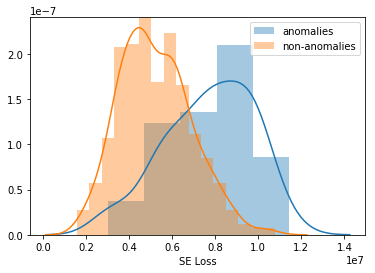

In [185]:
total_se_loss = ((generator(encoder(train_data_mnist.cuda())[0]) - train_data_mnist.cuda())**2).sum([1, 2,3])

sns.distplot(total_mse_loss[train_label_mnist].detach().cpu().numpy(), label='anomalies')
sns.distplot(total_mse_loss[~train_label_mnist].detach().cpu().numpy(), label='non-anomalies')
plt.xlabel('SE Loss')
plt.legend()

In [186]:
roc_auc_score(train_label_mnist.numpy(), total_mse_loss.detach().cpu().numpy())

0.8210730088495576

## izi-f

In [187]:
import torch.nn.functional as F

def izi_f_loss(x,G_z,k = 1): # расстояние до аномалии x до ближайшего соседа G_z
    _, x_feature = discriminator(x)
    _, G_z_feature = discriminator(G_z)

    discrimination_loss = torch.sum((x_feature-G_z_feature)**2, 1)/x.shape[0]

    total_loss = F.mse_loss(x, G_z) + k*discrimination_loss
    return total_loss

In [188]:
encoder = Encoder().cuda()
opt_E = torch.optim.Adam(encoder.parameters(),lr=1e-4) # задаём оптимизатор для поиска ближайшего z к нашим аномалиям

In [190]:
experiment = Experiment(api_key = 'fcQ6lceLdmViH5KysjfD4mkz7', project_name='AnoGAN—MNIST—izi', workspace='Sirius-yandex-2019')

step = 0

for epoch in range(30):
    print(epoch)
    
    for i, (imgs, _) in enumerate(not_ano_loader):
        opt_E.zero_grad()
        
        encoded_vec = encoder(imgs.cuda())[0]
        generated_imgs = generator(encoded_vec)
        loss_AE = izi_f_loss(imgs.cuda(), generated_imgs).mean()
        loss_AE.backward()
        
        opt_E.step()
        
        #experiment.log_metrics({'loss_AE': loss_AE.item()}, epoch = epoch, step = step)
        
        step += 1
        
    losses_test = []
    for i, (imgs, _) in enumerate(not_ano_loader_test):
        losses_test.append(MSE_AE(imgs.cuda(), generator(encoder(imgs.cuda())[0])).item())
    
    losses_test = np.array(losses_test)
    loss_test = losses_test.mean()
    
    experiment.log_metrics({'loss_AE_test': loss_test}, epoch = epoch, step = step)

        
experiment.end()

COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/sirius-yandex-2019/anogan-mnist-izi/e82a9b58aa324e6fb0ec8a85c1d01f0b
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     sys.gpu.0.free_memory    : (9319088128.0, 9319088128.0)
COMET INFO:     sys.gpu.0.gpu_utilization: (0.0, 0.0)
COMET INFO:     sys.gpu.0.total_memory   : (11995578368.0, 11995578368.0)
COMET INFO:     sys.gpu.0.used_memory    : (2676490240.0, 2676490240.0)
COMET INFO:     sys.gpu.1.free_memory    : (8824160256.0, 8824160256.0)
COMET INFO:     sys.gpu.1.gpu_utilization: (95.0, 95.0)
COMET INFO:     sys.gpu.1.total_memory   : (11995578368.0, 11995578368.0)
COMET INFO:     sys.gpu.1.used_memory    : (3171418112.0, 3171418112.0)
COMET INFO:     sys.gpu.2.free_memory    : (9537847296.0, 9537847296.0)
COMET INFO:     sys.gpu.2.gpu_utilization: (88.0, 88.0)
COMET INFO:     sys.gpu.2.total_memory   : (11995578368.0, 11995578368.

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/sirius-yandex-2019/anogan-mnist-izi/0c62cf3815d24aaaa7019d11c48c176a
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [634]                    : (1.7892050743103027, 8.227752685546875)
COMET INFO:     loss_AE_test [30]             : (0.05944577977061272, 0.14928697049617767)
COMET INFO:     sys.gpu.0.free_memory [17]    : (9319088128.0, 9319088128.0)
COMET INFO:     sys.gpu.0.gpu_utilization [17]: (0.0, 0.0)
COMET INFO:     sys.gpu.0.total_memory        : (11995578368.0, 11995578368.0)
COMET INFO:     sys.gpu.0.used_memory [17]    : (2676490240.0, 2676490240.0)
COMET INFO:     sys.gpu.1.free_memory [17]    : (2692087808.0, 8824160256.0)
COMET INFO:     sys.gpu.1.gpu_utilization [17]: (0.0, 99.0)
COMET INFO:     sys.gpu.1.total_memory        : (11995578368.0, 11995578368.0)
COMET INFO:     sys.gpu.1.used_memory [17]    : (317141811

In [191]:
torch.save(encoder.state_dict(), "izi-f_encoder_state.pt")
torch.save(encoder, "izi-f_encoder.pt")

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


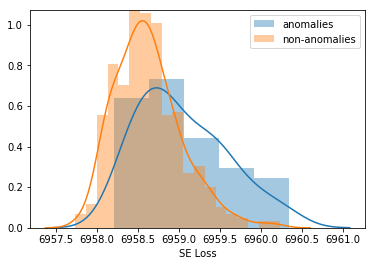

In [194]:
loss = izi_f_loss(train_data_mnist.cuda(), generator(encoder(train_data_mnist.cuda())[0]))

sns.distplot(loss[train_label_mnist].detach().cpu().numpy(), label='anomalies')
sns.distplot(loss[~train_label_mnist].detach().cpu().numpy(), label='non-anomalies')
plt.xlabel('SE Loss')
plt.legend()

In [195]:
roc_auc_score(train_label_mnist.numpy(), loss.detach().cpu().numpy())

0.7250875737463127

## ziz

In [197]:
encoder = Encoder().cuda()
opt_E = torch.optim.Adam(encoder.parameters(),lr=1e-4)
MSE_AE = nn.MSELoss()

In [199]:
experiment = Experiment(api_key = 'fcQ6lceLdmViH5KysjfD4mkz7', project_name='AnoGAN—MNIST—izi', workspace='Sirius-yandex-2019')

step = 0

Tensor = torch.cuda.FloatTensor

for epoch in range(30):
    print(epoch)
        
    for i in range(234):
        z = Variable(Tensor(np.random.normal(0, 1, (256, 100)))).to('cuda')

        opt_E.zero_grad()
        
        generated_imgs = generator(z.cuda())
        encoded_vec = encoder(generated_imgs)[0]
        loss_AE = MSE_AE(z, encoded_vec)*256/100
        loss_AE.backward()
        
        opt_E.step()
        
        #experiment.log_metrics({'loss_AE': loss_AE.item()}, epoch = epoch, step = step)
        
        step += 1
        
    losses_test = []
    for i, (imgs, _) in enumerate(not_ano_loader_test):
        losses_test.append(MSE_AE(imgs.cuda(), generator(encoder(imgs.cuda())[0])).item())
    
    losses_test = np.array(losses_test)
    loss_test = losses_test.mean()
    
    experiment.log_metrics({'loss_AE_test': loss_test}, epoch = epoch, step = step)

        
experiment.end()

COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/sirius-yandex-2019/anogan-mnist-izi/95ffbf346a5146f1a4d0a0805b5ade30
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     sys.gpu.0.free_memory    : (9319088128.0, 9319088128.0)
COMET INFO:     sys.gpu.0.gpu_utilization: (0.0, 0.0)
COMET INFO:     sys.gpu.0.total_memory   : (11995578368.0, 11995578368.0)
COMET INFO:     sys.gpu.0.used_memory    : (2676490240.0, 2676490240.0)
COMET INFO:     sys.gpu.1.free_memory    : (4847960064.0, 4847960064.0)
COMET INFO:     sys.gpu.1.gpu_utilization: (81.0, 81.0)
COMET INFO:     sys.gpu.1.total_memory   : (11995578368.0, 11995578368.0)
COMET INFO:     sys.gpu.1.used_memory    : (7147618304.0, 7147618304.0)
COMET INFO:     sys.gpu.2.free_memory    : (9537847296.0, 9537847296.0)
COMET INFO:     sys.gpu.2.gpu_utilization: (89.0, 89.0)
COMET INFO:     sys.gpu.2.total_memory   : (11995578368.0, 11995578368.

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/sirius-yandex-2019/anogan-mnist-izi/21cfe65d08e14be4a7777466d7f46f4b
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [703]                    : (2.1362662315368652, 2.6099891662597656)
COMET INFO:     loss_AE_test [30]             : (0.13753001391887665, 0.21263882517814636)
COMET INFO:     sys.gpu.0.free_memory [14]    : (9319088128.0, 9319088128.0)
COMET INFO:     sys.gpu.0.gpu_utilization [14]: (0.0, 0.0)
COMET INFO:     sys.gpu.0.total_memory        : (11995578368.0, 11995578368.0)
COMET INFO:     sys.gpu.0.used_memory [14]    : (2676490240.0, 2676490240.0)
COMET INFO:     sys.gpu.1.free_memory [14]    : (2941648896.0, 4847960064.0)
COMET INFO:     sys.gpu.1.gpu_utilization [14]: (0.0, 94.0)
COMET INFO:     sys.gpu.1.total_memory        : (11995578368.0, 11995578368.0)
COMET INFO:     sys.gpu.1.used_memory [14]    : (71476183

In [200]:
torch.save(encoder.state_dict(), "models/encoder_models/ziz/ziz_encoder_state.pt")
torch.save(encoder, "models/encoder_models/ziz/ziz_encoder.pt")

False


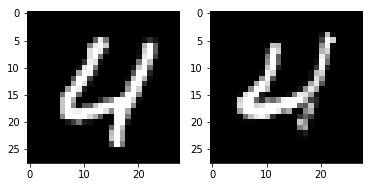




False


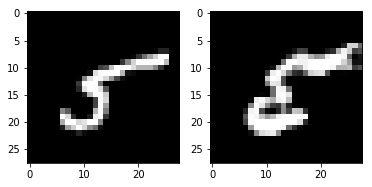




False


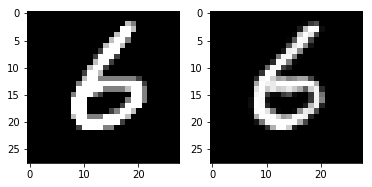




False


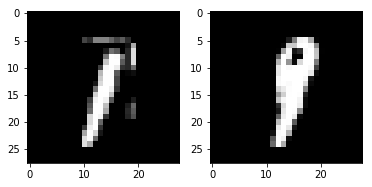




True


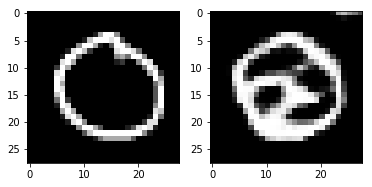




True


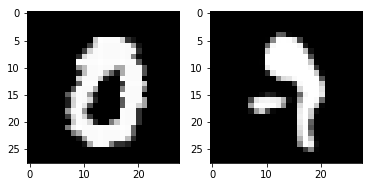




False


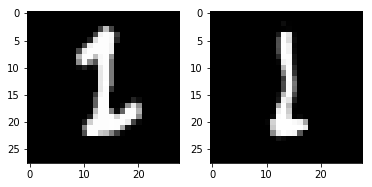




False


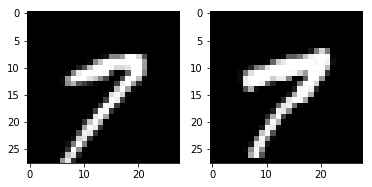




False


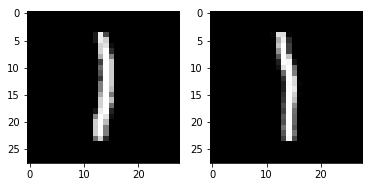




False


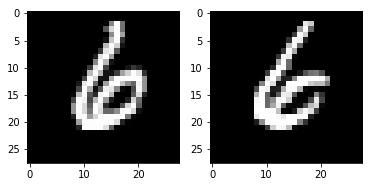

In [204]:
imgs = generator(encoder(train_data_mnist.cuda())[0])

for i in range(10):
    print(train_label_mnist[i].item())

    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(train_data_mnist.cpu().detach().numpy()[i][0], cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(imgs.cpu().detach().numpy()[i][0], cmap='gray')
    plt.show()

    print('\n\n')

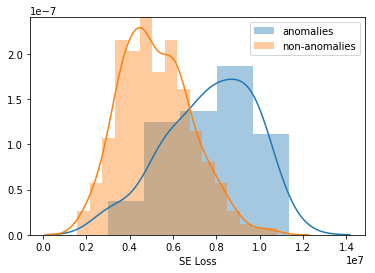

In [202]:
total_se_loss = ((generator(encoder(train_data_mnist.cuda())[0]) - train_data_mnist.cuda())**2).sum([1, 2,3])

sns.distplot(total_se_loss[train_label_mnist].detach().cpu().numpy(), label='anomalies')
sns.distplot(total_se_loss[~train_label_mnist].detach().cpu().numpy(), label='non-anomalies')
plt.xlabel('SE Loss')
plt.legend()

In [203]:
roc_auc_score(train_label_mnist.numpy(), total_se_loss.detach().cpu().numpy())

0.8204277286135693

False


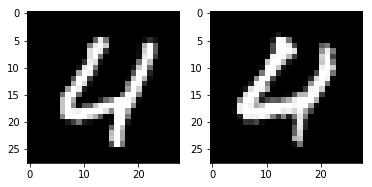




False


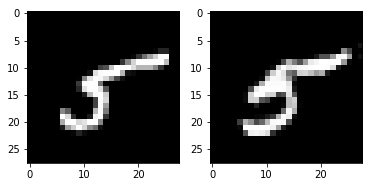




False


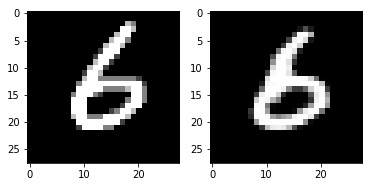




False


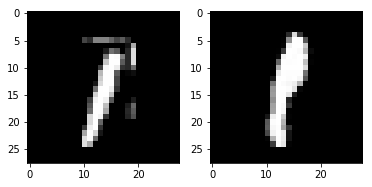




True


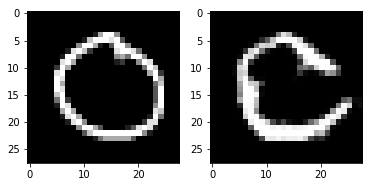




True


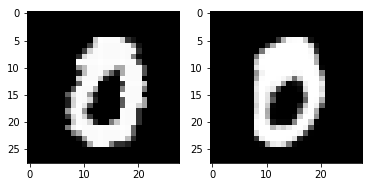




False


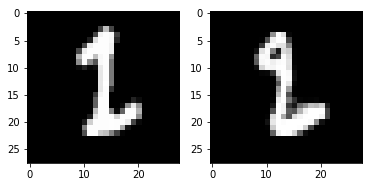




False


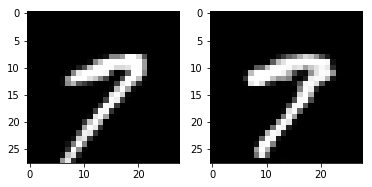




False


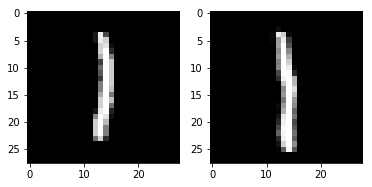




False


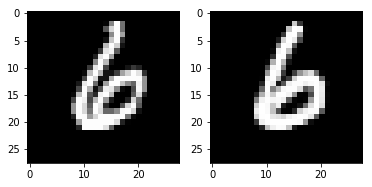

In [206]:
encoder.load_state_dict(torch.load("models/encoder_models/izi-f/izi-f_encoder_state.pt"))

imgs = generator(encoder(train_data_mnist.cuda())[0])

for i in range(10):
    print(train_label_mnist[i].item())

    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(train_data_mnist.cpu().detach().numpy()[i][0], cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(imgs.cpu().detach().numpy()[i][0], cmap='gray')
    plt.show()

    print('\n\n')

In [207]:
models_dict = {
    'izi':"models/encoder_models/izi/izi_encoder_state.pt",
    'izi-f':"models/encoder_models/izi-f/izi-f_encoder_state.pt",
    'ziz':"models/encoder_models/ziz/ziz_encoder_state.pt",
}